In [1]:
from PIL import Image, ImageStat
from PIL.ImageDraw import ImageDraw

import pandas as pd

from random import randint
from math import pi

import os
from os import path

In [2]:
def random_point(w, h, minx=0, miny=0):
    x, y = randint(minx, w), randint(miny, h)
    return (x, y)

def area_ellipse(p1, p2):
    x1, y1 = p1
    x2, y2 = p2
    x_len = abs(x1 - x2)
    y_len = abs(y1 - y2)
    return pi * x_len * y_len

def gen_example(w, h, num_polygons=1):
    example = Image.new('1', (w, h))
    draw = ImageDraw(example, mode='1')

    total_area = w * h
    area = 0
    for i in range(num_polygons):
        p1 = random_point(w, h)
        p2 = random_point(w, h, p1[0], p1[1])
        draw.rectangle([p1, p2], fill=1)

    (covered_area, ) = ImageStat.Stat(example).sum
    area = covered_area / total_area
    return (example, area)

In [3]:
DT_ROOT_DIR = path.join('./polygon_data')
DT_ROOT_DIR = path.abspath(DT_ROOT_DIR)
DT_LEN = 1000
W, H = 512, 512


def gen_df(root_dir, dt_len, img_size=(512, 512)):
    root_dir = path.abspath(root_dir)
    img_dir = path.join(root_dir, 'images')
    for directory in [root_dir, img_dir]:
        if not path.exists(directory):
            os.makedirs(directory)
            print(f"Created directory {directory}")

    df = pd.DataFrame(columns=['filename', 'area'])
    for i in range(dt_len):
        filename = f"img_{i}.jpeg"
        dest_path = path.join(img_dir, filename)
        img, area = gen_example(*img_size)
        img.save(dest_path)
        row = pd.Series({"filename": filename, "area": area})
        df.loc[i] = row
    df_dest = path.join(root_dir, 'data.csv')
    df.to_csv(df_dest)
    return df

df = gen_df(DT_ROOT_DIR, DT_LEN)

In [11]:
from fastai.vision import cnn_learner, ImageList, FloatList, get_transforms
from fastai.callbacks import EarlyStoppingCallback
from fastai.train import ShowGraph
from torchvision import models
from torch import nn
from functools import partial

class PolygonList(ImageList):
    def open(self, filename):
        return Image.open(filename).convert('1')

bunch = (PolygonList.from_df(path=path.join(DT_ROOT_DIR, 'images'), df=df)
            .split_by_rand_pct()
            .label_from_df(cols=1, label_cls=FloatList)
            .transform(size=(224, 224))
            .databunch(bs=1, device='cuda')  
        )

Exception: It's not possible to apply those transforms to your dataset:
 'Image' object has no attribute 'apply_tfms'

In [8]:
l1 = nn.MSELoss()
loss_func = lambda i,t: l1(i.squeeze(), t)
model = lambda x: nn.Sequential(
    nn.Conv2d(1, 3, 3),
    nn.MaxPool2d(2),
    nn.Conv2d(3, 3, 3),
    nn.MaxPool2d(2),
    nn.Conv2d(3, 3, 3),
    nn.MaxPool2d(2),
    nn.Conv2d(3, 3, 3),
    nn.MaxPool2d(2),
)
    
learn = cnn_learner(
    data=bunch,
    base_arch=model,
    cut=lambda x: x,
    loss_func=loss_func,
    callback_fns=[ShowGraph, partial(EarlyStoppingCallback, patience=10)],
    silent=True
)

/home/victor/Git/areacnn/polygon_data/images/img_0.jpeg


AttributeError: 'NoneType' object has no attribute 'size'

In [7]:
learn.fit(50)

RuntimeError: Given groups=1, weight of size 3 1 3 3, expected input[1, 3, 224, 224] to have 1 channels, but got 3 channels instead

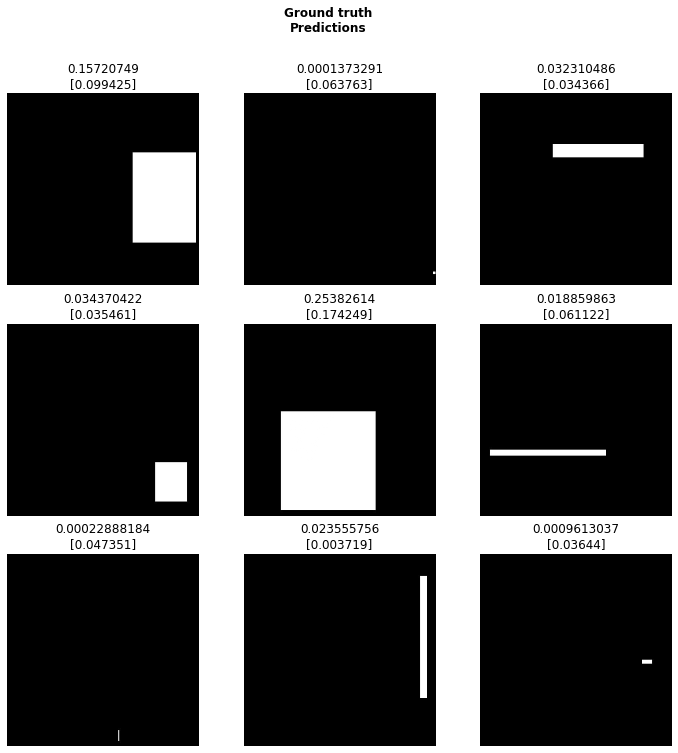

In [21]:
learn.show_results(rows=3)